In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import json
from textblob import TextBlob
from sklearn.cross_validation import cross_val_score
import metrics
from sklearn.cross_validation import train_test_split

plt.rcParams["figure.figsize"] = (10, 8)

In [2]:
def contest_metric(numpy_array_predictions, numpy_array_actual_values):
    return metrics.weighted_rmsle(numpy_array_predictions, numpy_array_actual_values,
            weights=metrics.KEEPING_IT_CLEAN_WEIGHTS)

In [3]:
def contest_scoring(X, y, pipeline):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    s1 = pipeline.fit(X_train, y_train['score_lvl_1']).predict(X_test)
    s2 = pipeline.fit(X_train, y_train['score_lvl_2']).predict(X_test)
    s3 = pipeline.fit(X_train, y_train['score_lvl_3']).predict(X_test)
    results = np.dstack((s1, s2, s3))
    score = contest_metric(np.round(results[0]), np.array(y_test))
    print("Contest score of {}".format(score))
    return score

In [4]:
def score_model(X, y, pipeline):
    scores = cross_val_score(pipeline, X, y, cv=3, n_jobs=1, verbose=1)
    mean_score = np.mean(scores)
    std_dev_score = np.std(scores)
    print("CV score of {} +/- {}".format(mean_score, std_dev_score))

In [5]:
def extract_features(df):
    features = df.drop(['score_lvl_1', 'score_lvl_2', 'score_lvl_3'], axis=1)
    response = df[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']].astype(np.float64)  #for numerical progression
    # response = df[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']].astype(np.int8)  # for categorical response
    return features, response


In [6]:
def fit_and_submit(train_df, test_df, pipeline, filename):
    X_test, y_test = extract_features(test_df)
    X_train, y_train = extract_features(train_df)

    if vectorized_docs_train and feature_list:
        X_train = hstack([vectorized_docs_train[1], coo_matrix(X_train)])
        X_test = hstack([vectorized_docs_test[1], coo_matrix(X_test)])
        logPrint('Matrices combined')
    elif vectorized_docs_train and not feature_list:
        X_train = vectorized_docs_train[1]
        X_test = vectorized_docs_test[1]
    elif not vectorized_docs_train and feature_list:
        pass
    elif not vectorized_docs_train and not feature_list:
        print('whoops!')

    # predict the counts for the test set
    if feature_list:
        s1 = pipeline.fit(X_train[feature_list], y_train['score_lvl_1']).predict(X_test[feature_list])
        s2 = pipeline.fit(X_train[feature_list], y_train['score_lvl_2']).predict(X_test[feature_list])
        s3 = pipeline.fit(X_train[feature_list], y_train['score_lvl_3']).predict(X_test[feature_list])
    else:
        s1 = pipeline.fit(X_train, y_train['score_lvl_1']).predict(X_test)
        s2 = pipeline.fit(X_train, y_train['score_lvl_2']).predict(X_test)
        s3 = pipeline.fit(X_train, y_train['score_lvl_3']).predict(X_test)
    predictions = np.dstack((s1, s2, s3))[0]

    # clip the predictions so they are all greater than or equal to zero
    # since we can't have negative counts of violations
    # SHOULD TRY CLIPPING AFTER AVERAGING SCORES ALSO
    predictions = np.clip(predictions, 0, np.inf)

    # averaging by mean, SHOULD TRY ALT METHODS OF GROUPING SCORES TOGETHER
    test_df[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']] = predictions
    submission_scores = test_df.groupby(['restaurant_id', 'inspection_date', 'inspection_id'])['score_lvl_1', 'score_lvl_2', 'score_lvl_3'].mean()
    temp = submission_scores.reset_index().set_index('inspection_id')

    # write the submission file
    new_submission = data_grab.get_submission()
    indexed_prediction = temp.reindex(new_submission.index)
    if new_submission.shape != indexed_prediction.shape:
        logPrint("ERROR: Submission and prediction have different shapes")
    new_submission[['*', '**', '***']] = np.round(indexed_prediction[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']]).astype(np.int8)
    new_submission.to_csv('predictions/'+filename)

In [7]:
vectorized_docs_train = None
feature_list = ['time_delta', 'review_stars', 'restaurant_id']

In [8]:
import data_grab
train_df = data_grab.get_selects('train', feature_list)
test_df = data_grab.get_selects('test', feature_list)

In [44]:
train_df.review_stars.dropna(inplace=True)
test_df.review_stars.dropna(inplace=True)

In [65]:
for i in train_df.groupby('restaurant_id'):
    score_model(i[1][['time_delta', 'review_stars']], i[1][['score_lvl_1', 'score_lvl_2', 'score_lvl_3']], pipeline)
    break

CV score of -2.12632078681 +/- 2.50842360125


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


In [49]:
train_df.groupby('restaurant_id')

AttributeError: Cannot access callable attribute 'iterrows' of 'DataFrameGroupBy' objects, try using the 'apply' method

In [886]:
# index = train_df['restaurant_id'].index[train_df['restaurant_id'].apply(np.isnan)]

In [1058]:
tdmax = train_df.time_delta.max()
tdmin = train_df.time_delta.min()
train_df['time_delta_bin'] = pd.cut(train_df["time_delta"], np.arange(tdmin, tdmax, 50))

In [1059]:
grouped = train_df.groupby(['time_delta_bin', 'review_stars']).mean()

In [1109]:
grouped = train_df.groupby(['time_delta_bin', 'review_stars']).median()
grouped = grouped.dropna().astype(int)

In [947]:
grouped = train_df.groupby(['time_delta', 'review_stars']).mean()

In [1038]:
no_future = grouped[grouped.time_delta > -1 ]

X, y = extract_features(grouped.reset_index())
X_past, y_past = extract_features(no_future.reset_index())

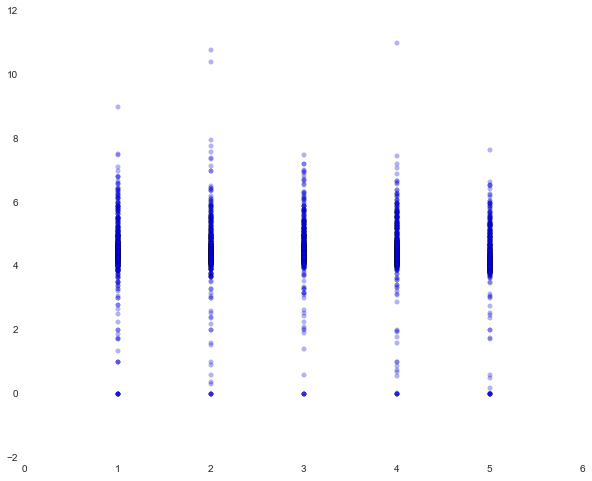

In [998]:
plt.scatter(X[['review_stars']], y['score_lvl_1'], alpha=0.3)

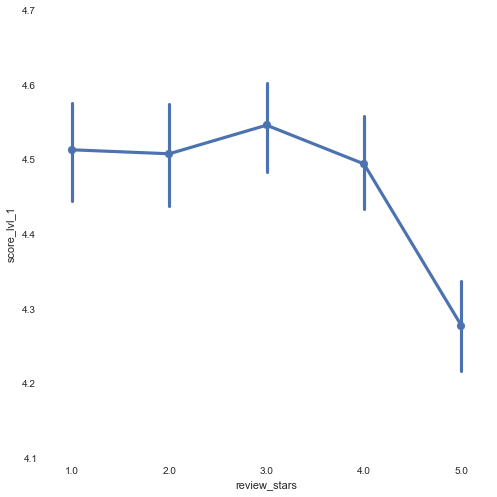

In [999]:
sns.factorplot(x='review_stars', y='score_lvl_1', data=grouped.reset_index(), size=7)

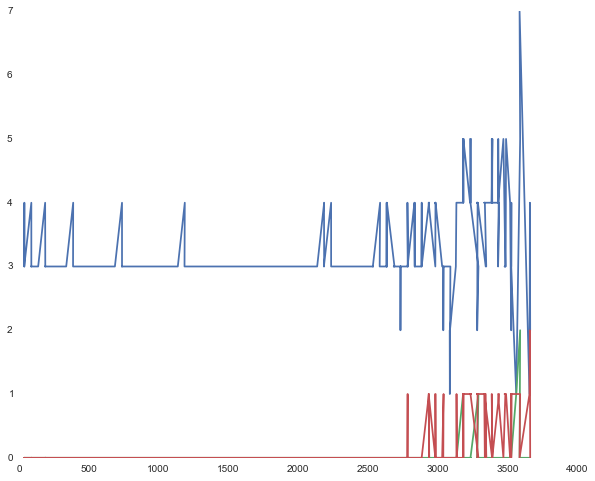

In [1376]:
plt.plot(X_past[['time_delta']], y_past)

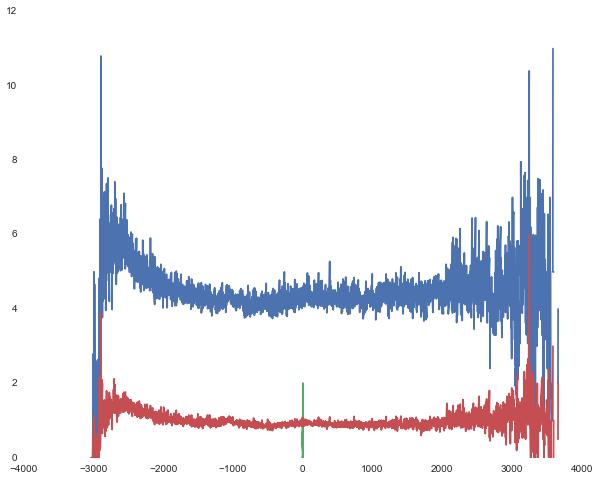

In [1001]:
plt.plot(X[['time_delta', 'review_stars']], y)

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('est', LinearRegression()),
                    ])

In [1373]:
no_future = grouped[grouped.time_delta > -1 ]

X_train, y = extract_features(grouped.reset_index())
X_past, y_past = extract_features(no_future.reset_index())

In [1374]:
no_future_train = train_df[train_df.time_delta > -1 ]
X_train, y_train = extract_features(no_future_train.reset_index())

In [1375]:
X = X_train[['review_stars', 'time_delta']]
y = y_train
for i in y:
    single_y = i
    score_model(X, y[single_y], pipeline)
contest_scoring(X, y_past, pipeline)

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.5min finished


CV score of 0.210398234722 +/- 0.00168617619299
CV score of 0.690653808436 +/- 0.00126085008659

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.4min finished



CV score of 0.570605756782 +/- 0.00151833976506


ValueError: Found arrays with inconsistent numbers of samples: [    361 1925254]

In [1325]:
import statsmodels.api as sm
X = X_past.review_stars
X = sm.add_constant(X, prepend=False)
model = sm.OLS(y_past['score_lvl_1'],X)
results = model.fit()

In [1326]:
# results.summary()

In [1354]:
X = X_past[['review_stars', 'time_delta']]
y = y_past
for i in y:
    single_y = i
    score_model(X, y[single_y], pipeline)
contest_scoring(X, y_past, pipeline)

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


CV score of 0.582254213161 +/- 0.269734759795
CV score of 0.875068870523 +/- 0.147399954389
CV score of 0.735090156281 +/- 0.247859663192
Contest score of 0.311365439924


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


0.3113654399238821

In [1355]:
tdmax = test_df.time_delta.max()
tdmin = test_df.time_delta.min()
test_df['time_delta_bin'] = pd.cut(test_df["time_delta"], np.arange(tdmin, tdmax, 50))
# grouped_test = test_df.groupby(['time_delta_bin', 'review_stars']).mean()

# making a clasiffier
grouped = train_df.groupby(['time_delta_bin', 'review_stars']).median()
grouped = grouped.dropna().astype(int)

In [1356]:
no_future_test = grouped_test[grouped_test.time_delta > -1 ]
X_test, y_test = extract_features(no_future_test.reset_index())

In [1357]:
X_test = X_test[['review_stars', 'time_delta']]

In [1358]:
s1 = pipeline.fit(X, y['score_lvl_1']).predict(X_test)
s2 = pipeline.fit(X, y['score_lvl_2']).predict(X_test)
s3 = pipeline.fit(X, y['score_lvl_3']).predict(X_test)

In [1359]:
predictions = np.dstack((s1, s2, s3))[0]

# clip the predictions so they are all greater than or equal to zero
# since we can't have negative counts of violations
# SHOULD TRY CLIPPING AFTER AVERAGING SCORES ALSO
predictions = np.clip(predictions, 0, np.inf)

In [1360]:
submission_map = no_future_test.copy().reset_index()

In [1361]:
submission = test_df.copy()

In [1362]:
submission.drop(['score_lvl_1', 'score_lvl_2', 'score_lvl_3'], axis=1, inplace=True)

In [1363]:
submission_map[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']] = predictions

In [1364]:
submission_map.drop(['inspection_id', 'time_delta'], axis=1, inplace=True)

In [1365]:
merged = pd.merge(submission, submission_map.reset_index(), on=['time_delta_bin', 'review_stars'], how='left')

In [1366]:
merged_scores = merged.groupby(['restaurant_id', 'inspection_date', 'inspection_id'])['score_lvl_1', 'score_lvl_2', 'score_lvl_3'].max()
temp = merged_scores.reset_index().set_index('inspection_id')


In [1370]:
temp.score_lvl_1.value_counts()

3    3550
4    2987
5     232
7       3
dtype: int64

In [1371]:
temp.score_lvl_1.fillna(temp.score_lvl_1.median(), inplace=True)
temp.score_lvl_2.fillna(temp.score_lvl_2.median(), inplace=True)
temp.score_lvl_3.fillna(temp.score_lvl_3.median(), inplace=True)


In [1372]:
filename = 'forest_review_stars.csv'
# write the submission file
new_submission = data_grab.get_submission()
indexed_prediction = temp.reindex(new_submission.index)
if new_submission.shape != indexed_prediction.shape:
    logPrint("ERROR: Submission and prediction have different shapes")
new_submission[['*', '**', '***']] = np.round(indexed_prediction[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']]).astype(np.int8)
new_submission.to_csv('predictions/'+filename)

In [943]:
new_submission.shape

(6772, 5)

# need to measure predictive power of a single review and give those with more power more weight when averaging

In [85]:
s1 = pipeline.fit(X_train, y_train['score_lvl_1']).predict(X_test)
s2 = pipeline.fit(X_train, y_train['score_lvl_2']).predict(X_test)
s3 = pipeline.fit(X_train, y_train['score_lvl_3']).predict(X_test)

In [86]:
results = np.dstack((s1, s2, s3))

In [87]:
results[0].shape

(463075, 3)

In [92]:
test_df.shape

(1044138, 132)

In [3]:
import gensim
model = gensim.models.Word2Vec.load('models/word2vec_model')

In [16]:
model.similarity('gross', 'icki')

0.59088660927079761

In [88]:
model.most_similar('protect')

[(u'sensor', 0.6822803020477295),
 (u'shield', 0.6779543161392212),
 (u'oppon', 0.6720187664031982),
 (u'liner', 0.6624016761779785),
 (u'bozo', 0.6599942445755005),
 (u'northfac', 0.6596208810806274),
 (u'wearer', 0.6580789685249329),
 (u'spew', 0.6561436653137207),
 (u'slur', 0.6538406610488892),
 (u'headphon', 0.653657078742981)]

In [103]:
max_list = []
for doc in t_list:
    doc_score = 0
    for word in doc:
        try:
            score = model.similarity('gross', word)
            if score > doc_score:
                doc_score = score
        except:
            pass
    max_list.append(doc_score)

In [108]:
m = max(max_list)
[i for i, j in enumerate(max_list) if j == m]

[46]

In [31]:
test.cat.codes.head(10)

0    198035
1     70191
2     33389
3    188493
4    227482
5    188848
6    201654
7    201654
8    201654
9    201654
dtype: int32

In [44]:
test.cat.categories[198035]

'This is a pretty typical cafe.  The sandwiches and wraps are good but a little overpriced and the food items are the same.  The chicken caesar salad wrap is my favorite here but everything else is pretty much par for the course.'

In [41]:
test.head(8)

0    This is a pretty typical cafe.  The sandwiches...
1    I agree with other reviewers - this is a prett...
2    Decent enough food, but very overpriced. Just ...
3    The muffins are great...esp the blueberry!  I ...
4    Well, well, well, look at me reviewing the res...
5    The only place downtown where you can get away...
6    This is the place I like to go for deli sandwi...
7    This is the place I like to go for deli sandwi...
Name: review_text, dtype: category
Categories (251291, object): [!      .       ., ! T o f u ! T o f u !\n\n! D o f u ! D o f u!\..., ! the orange-lime juice is tasty.\n! they have..., !!     .., ..., 非常迷你的一間店，店內只有5個位置，但我們很幸運的有位置可以在店內享用餐點。\n我們點了Fa..., 非常迷你的一間店，店內只有5個位置，但我們很幸運的有位置可以在店內享用餐點。\n我們點了Fa..., 面包不错，然后，就没有然后了。我的豆腐汤泡饭还行，朋友的那个不知道什么就一般了。, 龍蝦麵還不錯吃\n份量非常大\n可以兩到三人分\n\n美中不足的是空間非常狹小 不收信用卡]